In [1]:
import os
import sys
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm
%matplotlib inline

<class 'SimpleITK.SimpleITK.Image'>
(306, 512, 512)
加窗前： -1024 1787
加窗后： -110.0 190.0
0.0 255.0
[-394.8500061   -50.40000153 -158.8999939 ]
[1.         0.68359375 0.68359375]


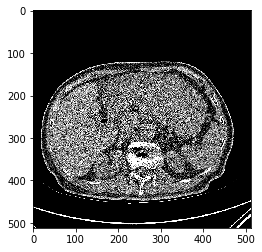

In [24]:
# used for test
'''


file = 'trainset/369542.mhd'
itkimage = sitk.ReadImage(file)
print(type(itkimage))

def window(image,width,center):
    print('加窗前：',np.min(image),np.max(image))
    up = width/2 + center
    down = center - width/2
    
    #image[image>up] = up
    #image[image<down] = down
    
    image = np.clip(image,down,up)
    print('加窗后：',np.min(image),np.max(image))

    return image
    
def normalize(image):
    img_max = np.max(image)
    img_min = np.min(image)
    y = np.rint((image-np.min(image))/(np.max(image)-np.min(image))*255)
    return y

def histogram_demo(image):
    plt.hist(image.ravel(), 256, [0, 256])#ravel函数功能是将多维数组降为一维数组
    plt.show()

# Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
ct_scan = sitk.GetArrayFromImage(itkimage)
print(ct_scan.shape)

img = ct_scan[10,:,:]
#img = window(img,2000,-500)
img = window(img,300,40) # 纵隔
img = normalize(img)   

#print(img)
print(np.min(img),np.max(img))
plt.imshow(img,cmap = 'gray')
#plt.figure(2)
#histogram_demo(img[img>0])

# 图像原点坐标（物理层面的，有单位，一般为mm，与spacing保持一致）
origin = np.array(list(reversed(itkimage.GetOrigin())))
print(origin)    # x, y, z

# spacing：图像各维度上像素之间的距离（物理层面的，有单位，一般为mm)
spacing = np.array(list(reversed(itkimage.GetSpacing())))    # 获取各个维度上像素的间隔 (z,y,x) 
print(spacing)


'''

In [2]:
def load_itk(file_name, file_path):
    '''
    modified from https://stackoverflow.com/questions/37290631/reading-mhd-raw-format-in-python
    '''
    
    # Reads the image using SimpleITK
    file = os.path.join(file_path, file_name + '.mhd')
    itkimage = sitk.ReadImage(file)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.  
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension   (z,y,x)
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    return ct_scan, origin, spacing
    

def plot_scan(seriesuid, anns_all, file_path, plot_path='visualization/', 
              clipmin= -1000, clipmax=600, only_df=False, return_ct=False):
    '''
    input:
    seriesuid: specify the scan plotted.
    anns_all:  the annotation provided (Dataframe).
    file_path: the path of the data.
    plot_path: the path of the visualization, default: make a subdirectory under the current dir.   
    clip_min:  the lower boundary which is used for clipping the CT valued for the lung window.
    clip_max:  the upper boundary which is used for clipping the CT valued for the lung window.
    only_df:   if True, only return the dataframe , and do not plot.
    return_ct: if True, return the dataframe with the ct array.
    
    return:
    ann_df:    return the annotation dataframe according to the seriesuid
    
    Mediastinum window: clipmin=-150, clipmax=250
    '''
    seriesuid = str(seriesuid)
    ann_df = anns_all.query('seriesuid == "%s"' % seriesuid).copy()   # Find Specific id
    
    ct, origin, spacing = load_itk(file_name=seriesuid, file_path=file_path)
    ct_clip = ct.clip(min=clipmin, max=clipmax)  # add windows
    
    # coordinate transform: world to voxel
    ann_df.coordX = (ann_df.coordX - origin[2]) / spacing[2]
    ann_df.coordY = (ann_df.coordY - origin[1]) / spacing[1]
    ann_df.coordZ = (ann_df.coordZ - origin[0]) / spacing[0]

    ann_df.diameterX = ann_df.diameterX / spacing[2]
    ann_df.diameterY = ann_df.diameterY / spacing[1]
    ann_df.diameterZ = ann_df.diameterZ / spacing[0]

    ann_df['labelstr'] = ann_df.label.apply(lambda x:label_dict[x])
    
    if ann_df.shape[0] == 0:
        print('no annoatation')
        del ct
        return ann_df
        
    # plot phase
    if not os.path.exists(plot_path): os.mkdir(plot_path)
    scan_plot_path = os.path.join(plot_path, seriesuid)
    if not os.path.exists(scan_plot_path): os.mkdir(scan_plot_path)  #plot_path
    
    
    for num in tqdm(range(ct_clip.shape[0])):
        
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        #print(ct_clip[num].shape)
        ax.imshow(ct_clip[num], cmap=plt.cm.gray)

        # iterrows 返回每行的索引及一个包含行本身的对象。
        for _, ann in ann_df.iterrows():
            x, y, z, w, h, d = ann.coordX, ann.coordY, ann.coordZ, ann.diameterX, ann.diameterY, ann.diameterZ
            color = 'r'
            
            # x,y为坐标位置，d为直径。num只要在z轴所在的长方形内那么就有标注。
            if num > z - d/2 and num < z + d / 2:
                    # Rectangle 第一个参数是矩形左上角点坐标 tuple (x,y)，第二个参数是矩形宽，第三个参数是矩形高
                ax.add_artist(plt.Rectangle((x - w / 2, y - h / 2), w, h, fill=False, color=color))   # 调整，使得矩形以x,y为中心
                
                text = label_dict[ann.label]
                ax.add_artist(plt.Text(x - w / 2, y - h / 2, text, size='x-large', color=color))  # 标注文字
                
                
                
        title = (3 - len(str(num))) * '0' + str(num)  # 标题
        ax.set_title(title)  #设置标题
        ax.axis('off')  #不要坐标轴
        plt.savefig(os.path.join(scan_plot_path, title), dpi=100)  #保存标注图片
        plt.close()

    del ct  # 释放ct空间？？
    return ann_df


def get_pics(seriesuid,ct_scan,file_path,clipmin= -1000, clipmax=600,save_path = 'pics/'):
    '''
    convert mdh to png, with windows range from -1000 to 600
    '''
    
    if not os.path.exists(save_path): os.mkdir(save_path)
    save_path = os.path.join(save_path, seriesuid)
    if not os.path.exists(save_path): os.mkdir(save_path)  #plot_path
    
    seriesuid = str(seriesuid)
    ct, origin, spacing = load_itk(file_name=seriesuid, file_path=file_path)
    ct_clip = ct.clip(min=clipmin, max=clipmax)  # add windows
    for num in tqdm(range(ct_clip.shape[0])):
        img = ct_clip[num]
        title = (3 - len(str(num))) * '0' + str(num)
        img = np.rint((img-np.min(img))/(np.max(img)-np.min(img))*255).astype(np.uint8)   # 归一化
        cv2.imwrite(os.path.join(save_path, title+'.png'),img)

        
def get_mask(seriesuid, anns_all, file_path, height=512, width=512, plot_path='mask/', 
              clipmin= -1000, clipmax=600,):
    '''
    get mask and save
    '''

    '''
    input:
    seriesuid: specify the scan plotted.
    anns_all:  the annotation provided (Dataframe).
    file_path: the path of the data.
    plot_path: the path of the visualization, default: make a subdirectory under the current dir.   
    clip_min:  the lower boundary which is used for clipping the CT valued for the lung window.
    clip_max:  the upper boundary which is used for clipping the CT valued for the lung window.
    only_df:   if True, only return the dataframe , and do not plot.
    return_ct: if True, return the dataframe with the ct array.
    
    return:
    ann_df:    return the annotation dataframe according to the seriesuid
    
    Mediastinum window: clipmin=-150, clipmax=250
    '''
    
    seriesuid = str(seriesuid)
    ann_df = anns_all.query('seriesuid == "%s"' % seriesuid).copy()   # Find Specific id
    ct, origin, spacing = load_itk(file_name=seriesuid, file_path=file_path)
    ct_clip = ct.clip(min=clipmin, max=clipmax)  # add windows
    del ct

    # coordinate transform: world to voxel
    ann_df.coordX = (ann_df.coordX - origin[2]) / spacing[2]
    ann_df.coordY = (ann_df.coordY - origin[1]) / spacing[1]
    ann_df.coordZ = (ann_df.coordZ - origin[0]) / spacing[0]

    ann_df.diameterX = ann_df.diameterX / spacing[2]
    ann_df.diameterY = ann_df.diameterY / spacing[1]
    ann_df.diameterZ = ann_df.diameterZ / spacing[0]
    
    
    if ann_df.shape[0] == 0:
        print('no annoatation')
        return 0
        
    # plot phase
    if not os.path.exists(plot_path): os.mkdir(plot_path)
    save_path = os.path.join(plot_path, seriesuid)
    if not os.path.exists(save_path): os.mkdir(save_path)  #plot_path
        
    for num in tqdm(range(ct_clip.shape[0])):
        mask = np.zeros([height,width])
        # iterrows 返回每行的索引及一个包含行本身的对象。
        for _, ann in ann_df.iterrows():
            # 只关注结节的标注
            if label_dict[ann.label] == 'nodule':
                x, y, z, w, h, d = ann.coordX, ann.coordY, ann.coordZ, ann.diameterX, ann.diameterY, ann.diameterZ
                # x,y为坐标位置，d为直径。
                if num > z - d/2 and num < z + d / 2:
                    for i in range(mask.shape[0]):
                        for j in range(mask.shape[1]):
                            if ((i-x)/w)**2 + ((j-y)/h)**2 < 1:
                                mask[j,i] = 255  # i,j倒过来？？？
        title = (3 - len(str(num))) * '0' + str(num)
        cv2.imwrite(os.path.join(save_path, title+'.png'),mask)
        del mask
        

In [3]:
def get_mix(seriesuid, anns_all, file_path, height=512, width=512, plot_path='mix/', 
              clipmin= -1000, clipmax=600,):
    '''
    get mask and save
    '''

    '''
    input:
    seriesuid: specify the scan plotted.
    anns_all:  the annotation provided (Dataframe).
    file_path: the path of the data.
    plot_path: the path of the visualization, default: make a subdirectory under the current dir.   
    clip_min:  the lower boundary which is used for clipping the CT valued for the lung window.
    clip_max:  the upper boundary which is used for clipping the CT valued for the lung window.
    only_df:   if True, only return the dataframe , and do not plot.
    return_ct: if True, return the dataframe with the ct array.
    
    return:
    ann_df:    return the annotation dataframe according to the seriesuid
    
    Mediastinum window: clipmin=-150, clipmax=250
    '''
    
    '''
    convert mdh to png, with windows range from -1000 to 600
    '''
    

    seriesuid = str(seriesuid)
    ann_df = anns_all.query('seriesuid == "%s"' % seriesuid).copy()   # Find Specific id
    ct, origin, spacing = load_itk(file_name=seriesuid, file_path=file_path)
    ct_clip = ct.clip(min=clipmin, max=clipmax)  # add windows
    del ct

    # coordinate transform: world to voxel
    ann_df.coordX = (ann_df.coordX - origin[2]) / spacing[2]
    ann_df.coordY = (ann_df.coordY - origin[1]) / spacing[1]
    ann_df.coordZ = (ann_df.coordZ - origin[0]) / spacing[0]

    ann_df.diameterX = ann_df.diameterX / spacing[2]
    ann_df.diameterY = ann_df.diameterY / spacing[1]
    ann_df.diameterZ = ann_df.diameterZ / spacing[0]
    
    
    # plot phase
    if not os.path.exists(plot_path): os.mkdir(plot_path)
    save_path = os.path.join(plot_path, seriesuid)
    if not os.path.exists(save_path): os.mkdir(save_path)  #plot_path
        
    for num in tqdm(range(ct_clip.shape[0])):
    
        img = ct_clip[num]
        img = np.rint((img-np.min(img))/(np.max(img)-np.min(img))*255).astype(np.uint8)   # 归一化    
        
        mask = np.zeros([height,width])
        # iterrows 返回每行的索引及一个包含行本身的对象。
        for _, ann in ann_df.iterrows():
            # 只关注结节的标注
            if label_dict[ann.label] == 'nodule':
                x, y, z, w, h, d = ann.coordX, ann.coordY, ann.coordZ, ann.diameterX, ann.diameterY, ann.diameterZ
                # x,y为坐标位置，d为直径。
                if num > z - d/2 and num < z + d / 2:
                    for i in range(mask.shape[0]):
                        for j in range(mask.shape[1]):
                            if ((i-x)/w)**2 + ((j-y)/h)**2 < 1:
                                mask[j,i] = 1  # i,j倒过来？？？
        mix = mask*img
        #mix[mix<0] = 0
        #mix[mix>0] = 255
        
        title = (3 - len(str(num))) * '0' + str(num)
        cv2.imwrite(os.path.join(save_path, title+'.png'),mix)
        del mix
        

In [4]:
label_dict = {}
label_dict[1]  = 'nodule'
label_dict[5]  = 'stripe'
label_dict[31] = 'artery'
label_dict[32] = 'lymph'vgg

seriesuid = '680023'
file_path = '../dataset/trainset'
anns_path = '../dataset/chestCT_round1_annotation.csv'
anns_all = pd.read_csv(anns_path)  #读取csv文件。


In [12]:
get_mix(seriesuid, anns_all, file_path)

100%|██████████| 56/56 [00:06<00:00,  9.27it/s]


In [5]:
plot_scan(seriesuid, anns_all, file_path)   # 默认是肺窗
#plot_scan(seriesuid, anns_all, file_path, clipmin=-150, clipmax=250,plot_path = 'zongge_anno/')   # 纵隔窗

100%|██████████| 53/53 [00:24<00:00,  1.90it/s]


,seriesuid,coordX,coordY,coordZ,diameterX,diameterY,diameterZ,label,labelstr
2577,680023,186.5,346.0,14.0,8.0,7.0,1.0,1,nodule
2578,680023,215.0,108.5,19.0,5.0,10.0,1.0,5,stripe
2579,680023,159.0,253.0,45.0,7.0,9.0,1.0,1,nodule


In [5]:
# get mask 
#get_mask(seriesuid, anns_all, file_path)
# get png format 

get_pics(seriesuid, anns_all, file_path,clipmin=-150, clipmax=250,save_path = 'zongge/')

100%|██████████| 54/54 [00:02<00:00, 24.74it/s]


In [10]:
import numpy as np 
import skimage 
from skimage.morphology import disk, binary_dilation, binary_erosion, binary_closing 
from skimage.segmentation import clear_border 
from skimage.measure import label,regionprops 
from skimage.filters import roberts 
from scipy import ndimage as ndi 


def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < -600
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

In [20]:
def get_lung(seriesuid,ct_scan,file_path,clipmin= -1000, clipmax=600,save_path = 'lung/'):
    '''
    convert mdh to png, with windows range from -1000 to 600
    '''
    
    if not os.path.exists(save_path): os.mkdir(save_path)
    save_path = os.path.join(save_path, seriesuid)
    if not os.path.exists(save_path): os.mkdir(save_path)  #plot_path
    
    seriesuid = str(seriesuid)
    ct, origin, spacing = load_itk(file_name=seriesuid, file_path=file_path)
    #ct_clip = ct.clip(min=clipmin, max=clipmax)  # add windows
    ct_clip = ct
    for num in tqdm(range(ct_clip.shape[0])):
        img = ct_clip[num]
        title = (3 - len(str(num))) * '0' + str(num)
        
        img = get_segmented_lungs(img)
        img = np.rint((img-np.min(img))/(np.max(img)-np.min(img))*255).astype(np.uint8)   # 归一化
        cv2.imwrite(os.path.join(save_path, title+'.png'),img)
get_lung(seriesuid, anns_all, file_path)

100%|██████████| 54/54 [00:08<00:00,  6.69it/s]


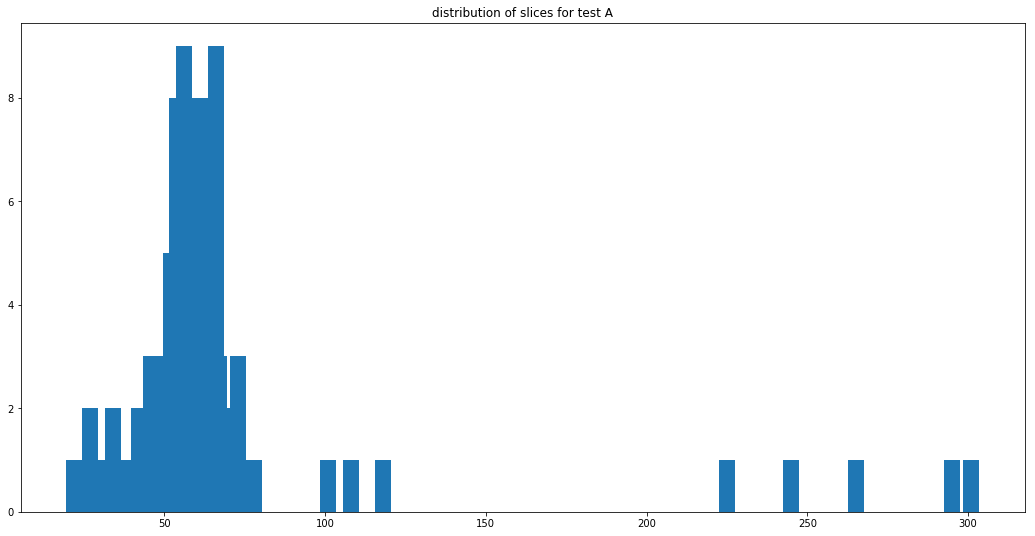

In [65]:
# 统计数量
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

def count_z(path = 'trainset_mask/'):
    count_dict = {}
    
    file_list = glob(path+'*')
    # print(file_list)
    for i in file_list:
        deep_path = i + '/'
        deep = glob(deep_path+'*')
        num = len(deep)
        
        if num not in count_dict.keys():
            count_dict[num] = 1
        else:
            count_dict[num]  = count_dict[num] +1
    #print(count_dict)
    
    x = []
    y = []
    for k,v in count_dict.items():
        x.append(k)
        y.append(v)
    
    array = np.array([x,y])
    
    #np.save("arr.npy", array)
    #print(x,y)
    x,y = np.load("arr.npy")
    plt.figure(figsize=(18,9))
    plt.bar(x,y,width = 5)
    #plt.title('distribution of slices')
    #plt.savefig('slices_distribution.png')
    
    plt.title('distribution of slices for test A')
    plt.savefig('testA_slices_distribution.png')

    count_z()

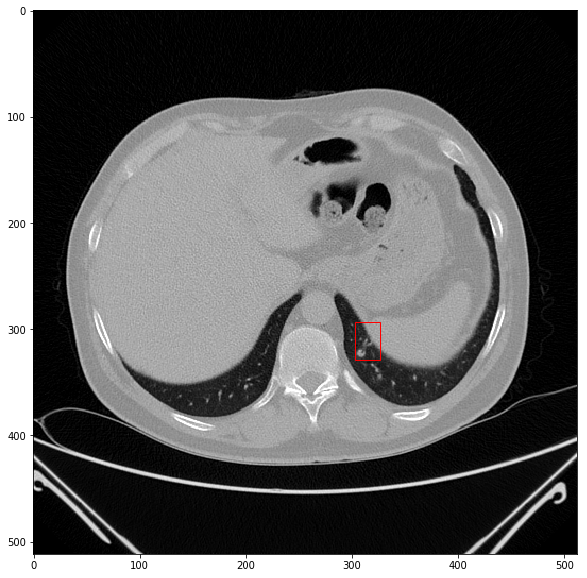

In [13]:
dataset = '../yolo/data/custom/'
uid = '388757_'
img_path = dataset+'images/'+uid+'.png'
text_path = dataset +'labels/'+ uid +'.txt'

img = cv2.imread(img_path)
with open(text_path,'r') as f:
    anno = f.readlines()
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    #print(ct_clip[num].shape)
    ax.imshow(img, cmap=plt.cm.gray)
    color = 'red'
    for i in anno:
        x = float(i.split()[1])*512
        y = float(i.split()[2])*512
        w = float(i.split()[3])
        h = float(i.split()[4])
        
        ax.add_artist(plt.Rectangle((x - w / 2, y - h / 2), w, h, fill=False, color=color))   # 调整，使得矩形以x,y为中心
                